In [371]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import venn
import warnings
warnings.filterwarnings("ignore")

### Concatenate files

In [372]:
# open other ncRNA db file
with open("/Users/hgibriel/Dropbox/sncRNAP/DBs/mouse_tRNAs-and-ncRNAs-and-lookalikes.fa_exc_miRNA.fa", "r") as file1:
    content1 = file1.read()

# open the miRNA db file
with open("/Users/hgibriel/Dropbox/mature.fa", "r") as file2:
    content2 = file2.read()

# concatenate the content of both files
concatenated_content = content1 + content2

# open concatenated file and count ncRNA classes
lines = concatenated_content.splitlines()


### A) ncRNA length

In [373]:
lengths = {}
ncRNA_id = None
for line in lines:
    if 'Mt' in line:
        continue

    if line.startswith(">"):
        if 'gene_biotype' in line and 'transcript_biotype' not in line:
            split_line = line.split('gene_biotype "')
            if len(split_line) >= 2:
                ncRNA_class = split_line[1].strip()
                ncRNA_class = ncRNA_class[:-2].strip('"')
                ncRNA_id = ncRNA_class + "_" + line.split(">")[1].split(" ")[0].split("\t")[0]
        if 'trna' in line:
            ncRNA_class = 'tRNA'
            ncRNA_id = ncRNA_class + "_" + line.split(">")[1].split(" ")[0].split("\t")[0]
        if 'mmu' in line:
            ncRNA_class = 'miRNA'
            ncRNA_id = ncRNA_class + "_" + line.split(">")[1].split(" ")[0].split("\t")[0]
        lengths[ncRNA_id] = 0
        
    if ('trna' not in line) and ('mmu' not in line) and ('gene_biotype' not in line) and (ncRNA_id is not None):
        lengths[ncRNA_id] += len(line.strip())
      
    if ('trna' not in line) and ('mmu' not in line) and ('gene_biotype' not in line):
        ncRNA_id = None

length_df = pd.DataFrame(list(lengths.items()), columns=['ncRNA_id', 'Length'])
length_df = length_df.dropna()
length_df.loc[length_df['ncRNA_id'].str.contains('tRNA'), 'Length'] = length_df.loc[length_df['ncRNA_id'].str.contains('tRNA'), 'Length'] - 100


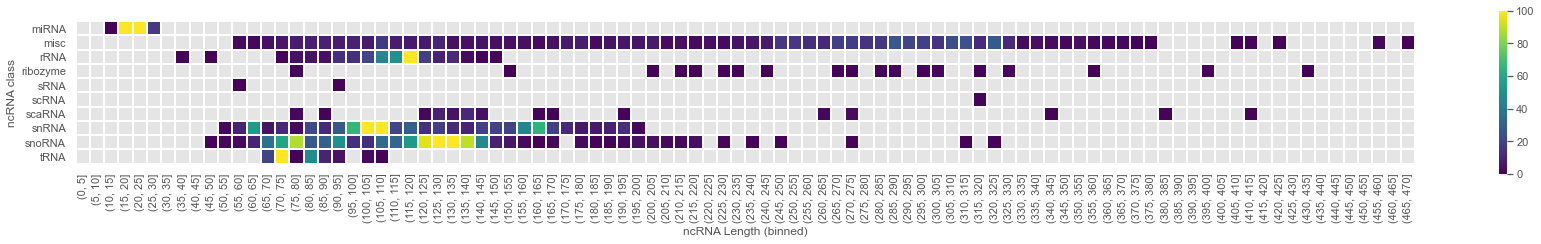

In [391]:
# create an empty list to store the results
data = []

# loop through each row in the length_df
for i, row in length_df.iterrows():
    # split the ncRNA_id column to extract the class
    ncRNA_class = row['ncRNA_id'].split('_')[0]
    length = row['Length']
    
    # add the ncRNA class and length to the data list
    data.append((ncRNA_class, length))

# create a new DataFrame from the data list
data_new = pd.DataFrame(data, columns=['ncRNA_class', 'Length'])

# remove length values > 500
data_new = data_new[data_new['Length'] <= 500]

# create a range of values to use for the bins
bins = range(0, int(data_new['Length'].max())+5, 5)

# bin the length values
data_new['binned'] = pd.cut(data_new['Length'], bins=bins)

# group the data by ncRNA class and binned length values
grouped = data_new.groupby(['ncRNA_class', 'binned']).count().reset_index()

# create a pivot table from the grouped data
pivot_table = grouped.pivot(index='ncRNA_class', columns='binned', values='Length')

# plot the heatmap
plt.figure(figsize=(30,3))
sns.heatmap(pivot_table, cmap='viridis',vmin=0, vmax=100, linewidth =1, square =True)
plt.xlabel('ncRNA Length (binned)')
plt.ylabel('ncRNA class')
plt.show()


### B) ncRNA count

In [392]:
# create a dictionary to store the counts ncRNA lasses
counts = {}

for line in lines:
    # ignore Mt_RNA
    if 'Mt' in line:
        continue
    
    # extract ncRNA class and ignore transcript ids
    if 'gene_biotype' and not 'transcript_biotype'in line:
        split_line = line.split('gene_biotype "')
        if len(split_line) >= 2:
            # extract the characters after gene_biotype "
            ncRNA_class = split_line[1].strip()
            ncRNA_class = ncRNA_class[:-2].strip('"')
            counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1

    # extract tRNAs   
    if 'trna' in line:
        split_line = line.split('trna')
        ncRNA_class = 'tRNA'
        counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1
        
    # extract miRNA
    if 'mmu' in line:
        split_line = line.split('mmu')
        ncRNA_class = 'miRNA'
        counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1

# create a dataframe to store the result
result_df = pd.DataFrame(list(counts.items()), columns=['ncRNA_class', 'Count'])

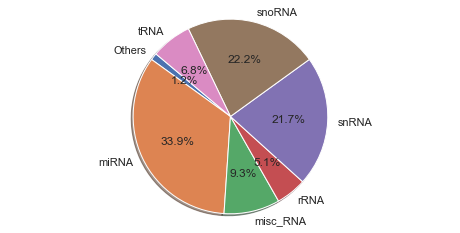

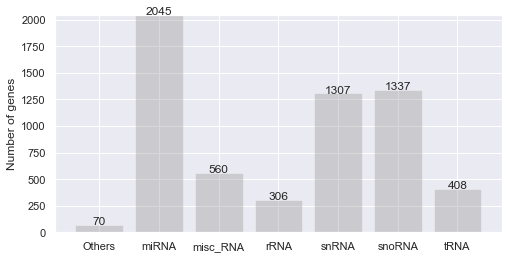

In [393]:
# plot gene count

# calculate the percentage of each class
result_df['Percentage'] = result_df['Count'] / result_df['Count'].sum() * 100

# Combine all classes with a percentage less than 5% into 'Others'
result_df.loc[result_df['Percentage'] < 5, 'ncRNA_class'] = 'Others'

# group the dataframe by the 'ncRNA_class' column
grouped_df = result_df.groupby('ncRNA_class').sum()

# plot the pie chart (Plot A)
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 4))
ax.pie(grouped_df['Percentage'], labels=grouped_df.index, autopct='%1.1f%%',
       shadow=True, startangle=140)
ax.axis('equal')

# add the counts as a bar plot (Plot B)
fig2, ax2 = plt.subplots(figsize=(8, 4))
bar_counts = grouped_df['Count']
ax2.bar(grouped_df.index, grouped_df['Count'], alpha=0.3, color='gray')
ax2.set_ylim(0, grouped_df['Count'].max())
ax2.set_ylabel('Number of genes')
ax2.set_ylim(0, grouped_df['Count'].max())

# add the counts on each bar in the barplot
for i, v in enumerate(bar_counts):
    ax2.text(i, v + 0.5, str(v), ha='center')

plt.show()

### C) ncRNA counts per sample

In [394]:
# Read the first CSV file
df1 = pd.read_csv("/Users/hgibriel/Dropbox/Results/DESeq/miRNA/C_vs_T.csv")
df1.head()

,"resultsDF[, 1]",log2FoldChange,pvalue,Ruth1,Ruth3,Ruth4,Ruth5
0,mmu-let-7a-1-3p,-0.112259,0.892374,11.132631,16.542352,10.000806,16.172036
1,mmu-let-7a-2-3p,-0.129967,0.945493,2.783158,1.985082,0.909164,3.465436
2,mmu-let-7a-5p,-0.066359,0.815150,354.852605,415.543876,393.668100,343.078191
3,mmu-let-7b-3p,-0.276426,0.559907,57.054733,50.288749,45.458210,42.740381
4,mmu-let-7b-5p,-0.098190,0.703746,694.397842,697.425549,672.781510,627.243965


In [395]:
# Read the second CSV file
df2 = pd.read_csv("/Users/hgibriel/Dropbox/Results/DESeq/non_miRNA/C_vs_T.csv")
df2.head()

,"resultsDF[, 1]",log2FoldChange,pvalue,Ruth1,Ruth3,Ruth4,Ruth5
0,chr1.trna1000-LeuCAG,0.229835,0.536857,1187.027382,778.268163,883.096026,1420.043860
1,chr1.trna1001-GlyGCC,0.387339,0.316563,530.157015,317.542648,444.075959,661.985229
2,chr1.trna1002-LeuCAG,0.236103,0.523599,1178.288530,788.660468,887.309270,1427.940304
3,chr1.trna1003-GlyGCC,0.416881,0.277517,537.439391,325.048202,464.299533,684.358487
4,chr1.trna1004-AspGTC,-0.038682,0.931562,155.842859,94.108094,96.061972,146.084215


#### concatenate dfs

In [396]:
# concatenate miRNA and other ncRNA dbs
conc_df = pd.concat([df1, df2])

# remove gene ids that have these names 'Mt|MT|lookalike'
conc_df = conc_df.rename(columns={conc_df.columns[0]: 'id'})
conc_df = conc_df[~conc_df['id'].str.contains('Mt|MT|lookalike')]
conc_df

,id,log2FoldChange,pvalue,Ruth1,Ruth3,Ruth4,Ruth5
0,mmu-let-7a-1-3p,-0.112259,0.892374,11.132631,16.542352,10.000806,16.172036
1,mmu-let-7a-2-3p,-0.129967,0.945493,2.783158,1.985082,0.909164,3.465436
2,mmu-let-7a-5p,-0.066359,0.815150,354.852605,415.543876,393.668100,343.078191
3,mmu-let-7b-3p,-0.276426,0.559907,57.054733,50.288749,45.458210,42.740381
4,mmu-let-7b-5p,-0.098190,0.703746,694.397842,697.425549,672.781510,627.243965
...,...,...,...,...,...,...,...
3952,ENSMUSG00000106106,-0.181596,0.545263,154590.289900,137822.169500,124757.537200,133069.559500
3953,ENSMUSG00000106163,-0.058924,0.967764,5.825901,3.464102,5.898542,2.632148
3954,ENSMUSG00000106307,-0.456784,0.409491,46.607210,51.961524,32.863306,39.482220
3955,ENSMUSG00000109440,-0.229935,0.822503,7.282377,13.279056,7.583840,10.528592


#### change id names to id_class

In [397]:
# Iterate over the ids 
for i, row in enumerate(conc_df['id']):

    # iterate over lines and match ncRNA class    
    for line in lines:

        # extract ncRNA class from ENS
        if "ENS" in row:
            if row in line:

                # extract ncRNA class and ignore transcript ids
                if 'gene_biotype' in line and 'transcript_biotype' not in line:
                    split_line = line.split('gene_biotype "')

                    # extract the characters after gene_biotype "
                    if len(split_line) >= 2:
                        ncRNA_class = split_line[1].strip()
                        ncRNA_class = ncRNA_class[:-2].strip('"')

                        # change row name to row name + ncRNA_class
                        new_id = row + "_" + ncRNA_class
                        conc_df['id'] = conc_df['id'].replace({row: new_id})

        # extract tRNAs   
        if 'trna' in row:
            if row in line:
                split_line = line.split('trna')
                ncRNA_class = 'tRNA'

                # change row name to row name + ncRNA_class
                new_id = row + "_" + ncRNA_class
                conc_df['id'] = conc_df['id'].replace({row: new_id})

        # extract species miRNA
        if 'mmu' in row:
            if row in line:
                split_line = line.split('mmu')
                ncRNA_class = 'miRNA'

                # change row name to row name + ncRNA_class
                new_id = row + "_" + ncRNA_class
                conc_df['id'] = conc_df['id'].replace({row: new_id})

In [398]:
# remove rows that don't have a classification
conc_df = conc_df[conc_df['id'].str.contains('_')==True]
conc_df = conc_df[~conc_df['id'].str.contains('Mt')]

#### check ncRNA counts across samples

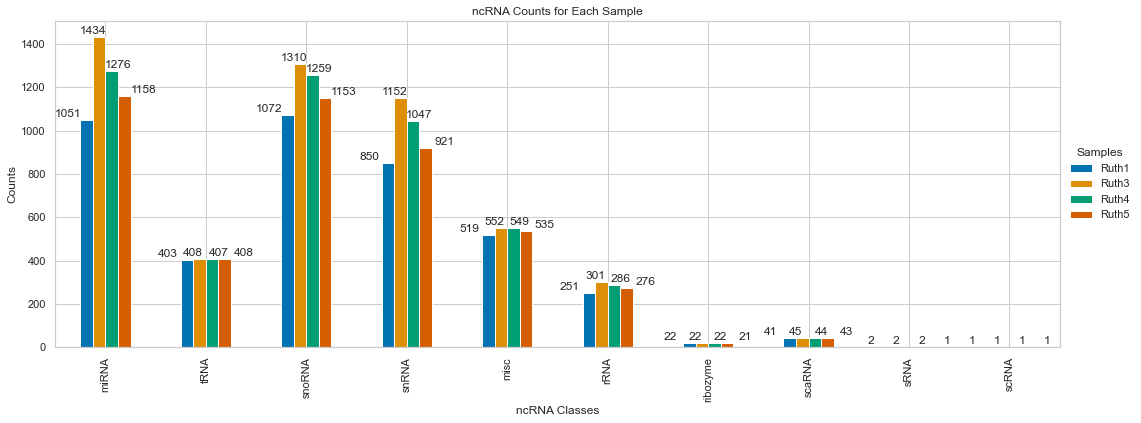

In [399]:
# iterate over column samples and find ids that with values !=0 
counts = {}
for column_name, column_values in conc_df.iloc[:, 3:].iteritems():
    sample_name = column_name
    sample_counts = {}
    for index, value in enumerate(column_values.values):
        if value == 0:
            continue
        row = conc_df.iloc[index, 0]
        
        split_line = row.split('_')
        ncRNA_class = split_line[1].strip()
        sample_counts[ncRNA_class] = sample_counts.get(ncRNA_class, 0) + 1

        counts[sample_name] = sample_counts
    
# create a dataframe to store the result
genes_classes_df = pd.DataFrame(counts)

# barplot
sns.set_style("whitegrid")
sns.set_palette("colorblind")

genes_classes_df.plot(kind='bar', stacked= False, figsize=(18, 6))

for i in range(genes_classes_df.shape[0]):
    for j in range(genes_classes_df.shape[1]):
        count = genes_classes_df.iloc[i, j]
        x_pos = i - 0.5 * (len(genes_classes_df.columns) - 1) / len(genes_classes_df.columns) + j / len(genes_classes_df.columns)
        y_pos = count + 5
        plt.text(x_pos, y_pos, str(count), ha='center', va='bottom')

plt.xlabel("ncRNA Classes")
plt.ylabel("Counts")
plt.title("ncRNA Counts for Each Sample")

plt.legend(title='Samples', frameon=False, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


#### venn diagram per ncRNA 

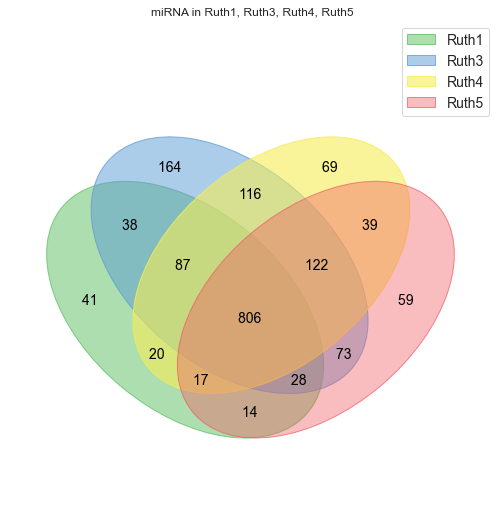

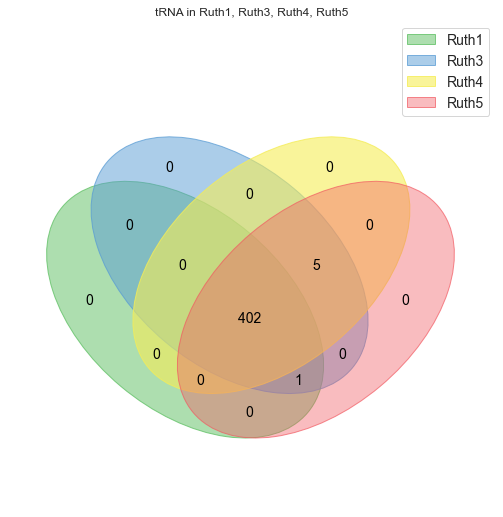

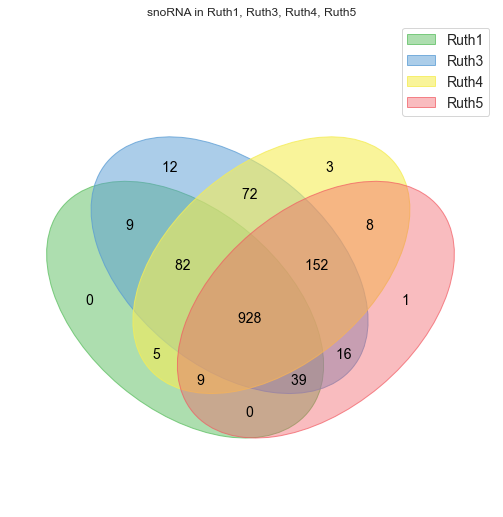

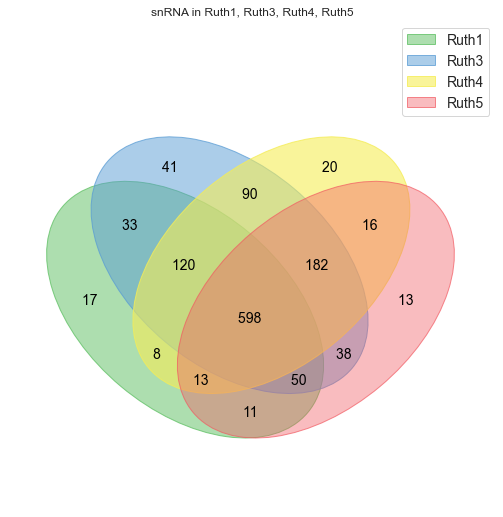

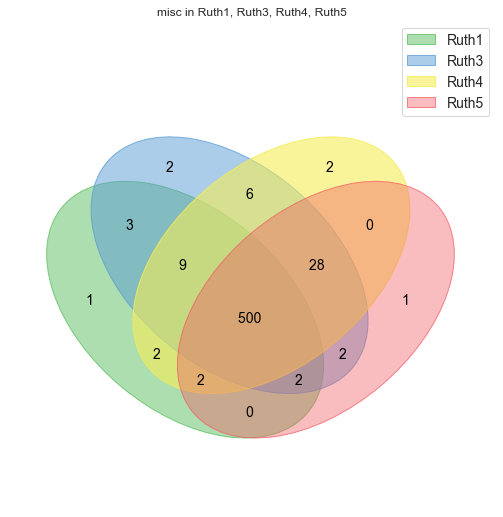

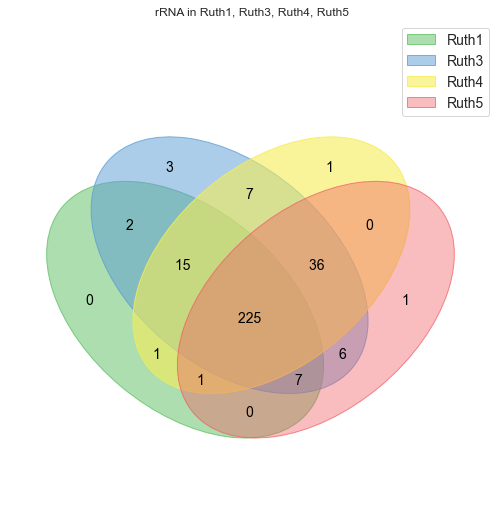

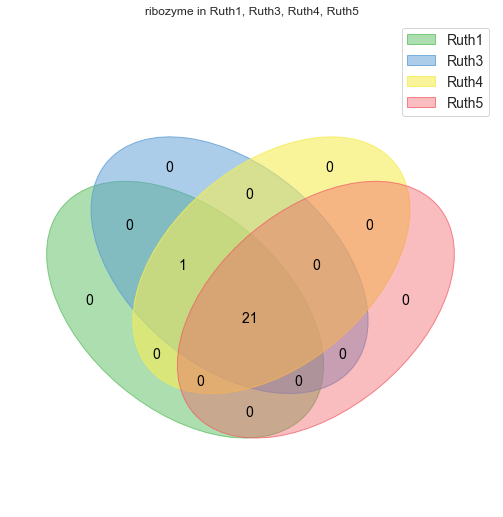

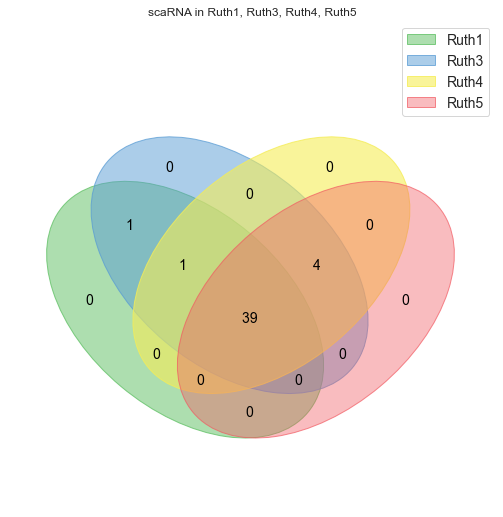

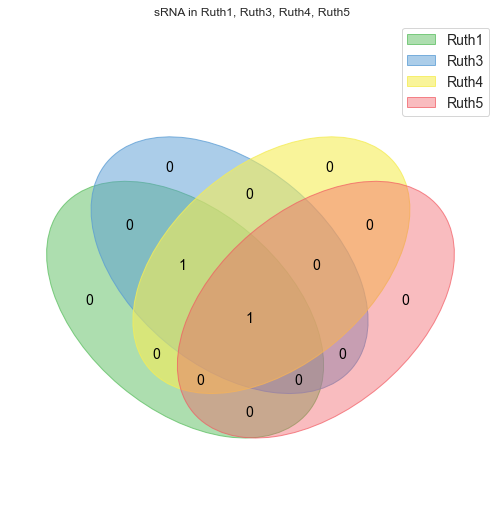

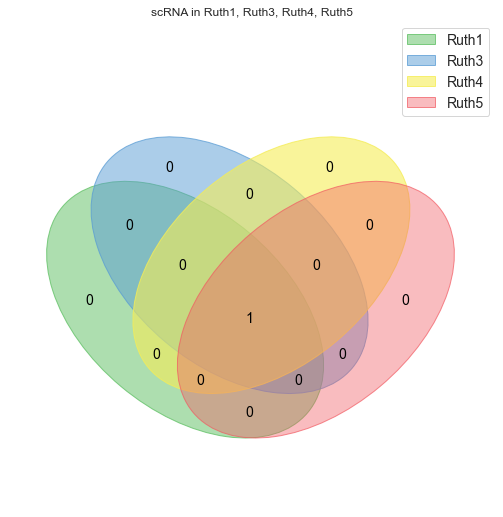

In [400]:
# create a venn df and convert values to 0/1
venn_conc_df = conc_df.drop(conc_df.columns[1:3], axis=1)

# convert values 
threshold = 0
venn_conc_df.iloc[:, 1:] = venn_conc_df.iloc[:, 1:].astype(float)
venn_conc_df.iloc[:, 1:] = venn_conc_df.iloc[:, 1:].applymap(lambda x: np.where(x > threshold, 1, 0))

# venn plot

# Extract sncRNA class from "id" column
venn_conc_df["sncRNA_class"] = venn_conc_df["id"].apply(lambda x: x.split("_")[1])

# Get unique classes
classes = venn_conc_df["sncRNA_class"].unique()

# Get unique sample names
sample_names = [col for col in venn_conc_df.columns if col not in ["id", "sncRNA_class"]]
sample_counts = len(sample_names)

# Plot Venn diagrams for each class
for class1 in classes:
    class1_data = venn_conc_df[venn_conc_df["sncRNA_class"] == class1].iloc[:, 1:]
    sets = []
    for sample in sample_names:
        sets.append(set(class1_data.index[class1_data[sample] > 0]))
    
    venn_function = getattr(venn, f'venn{sample_counts}')
    labels = venn.get_labels(sets, fill=['number'])
    fig, ax = venn_function(labels, names=sample_names)
    ax.set_title(f"{class1} in {', '.join(sample_names)}")
    
    fig.show()

#### expression profile per sample

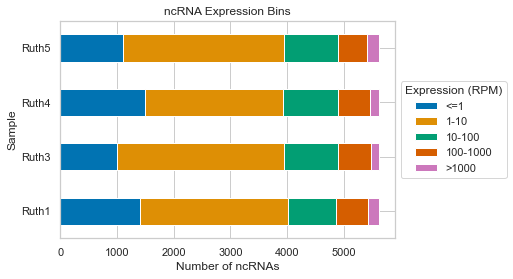

In [401]:
# Create bins for expression values
bins = [0, 1, 10, 100, 1000, float("inf")]
labels = ["<=1", "1-10", "10-100", "100-1000", ">1000"]

# Create a list to store the binned values for each sample
binned_values = []
for column_name, column_values in conc_df.iloc[:, 3:].iteritems():
    sample_name = column_name
    
    # Bin the expression values
    binned_expression_values = pd.cut(column_values, bins=bins, labels=labels, right=False, include_lowest=True)
    
    # Store the binned expression values for each sample
    binned_values.append(pd.DataFrame({'Expression Level': binned_expression_values, 'Sample': sample_name}))

# Concatenate the binned values for each sample
binned_df = pd.concat(binned_values)

# Pivot the data so that each expression level is a column and each sample is a row
binned_df = binned_df.pivot_table(index='Sample', columns='Expression Level', aggfunc='size').fillna(0)

# Plot the binned values as a stacked bar plot
binned_df.plot(kind='barh', stacked= True)
plt.xlabel("Number of ncRNAs")
plt.ylabel("Sample")
plt.title("ncRNA Expression Bins")
plt.legend(title="Expression (RPM)",loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()


#### expression profile per ncRNA class

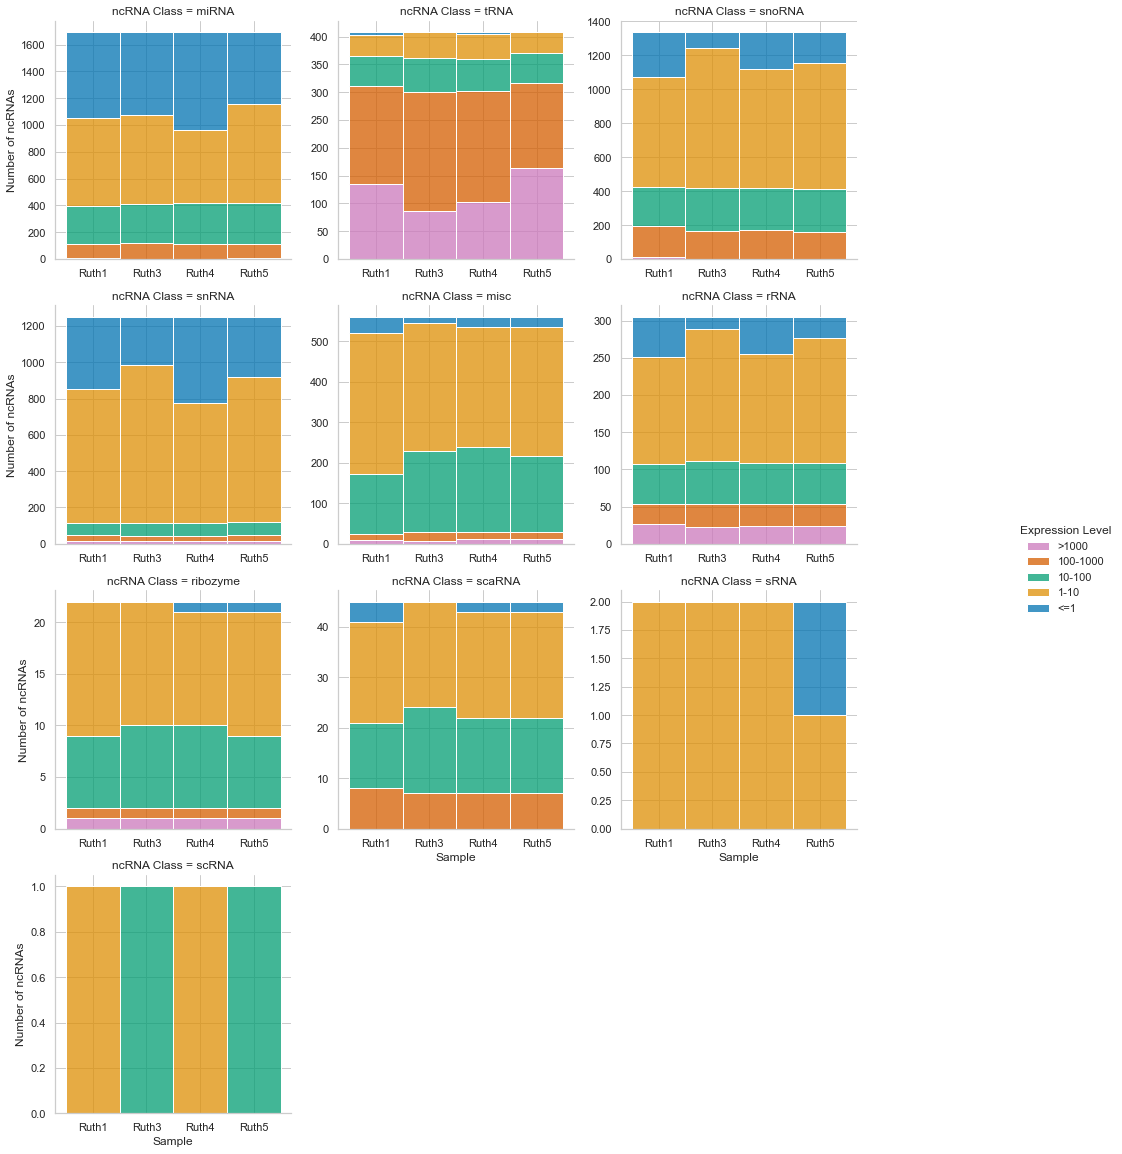

In [402]:
# Create bins for expression values
bins = [0, 1, 10, 100, 1000, float("inf")]
labels = ["<=1", "1-10", "10-100", "100-1000", ">1000"]

# Create a list to store the binned values for each sample and ncRNA class
binned_values = []
for column_name, column_values in conc_df.iloc[:, 3:].iteritems():
    sample_name = column_name
    
    # Bin the expression values
    binned_expression_values = pd.cut(column_values, bins=bins, labels=labels, right=False, include_lowest=True)
    
    # Store the binned expression values for each sample and ncRNA class
    sample_df = pd.DataFrame({'Expression Level': binned_expression_values, 'Sample': sample_name})
    sample_df['ncRNA Class'] = conc_df['id'].apply(lambda x: x.split('_')[1])
    binned_values.append(sample_df)

# Concatenate the binned values for each sample and ncRNA class
binned_df = pd.concat(binned_values)

# Plot each ncRNA class in a separate facet plot
g = sns.FacetGrid(binned_df, col='ncRNA Class', col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='Sample', hue='Expression Level', multiple='stack')
g.set_axis_labels('Sample', 'Number of ncRNAs')
g.add_legend(title='Expression Level', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0., ncol=1, title_fontsize=14, labels=labels[::-1])
plt.show()


### D) DE ncRNAs

In [403]:
conc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5622 entries, 0 to 3955
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5622 non-null   object 
 1   log2FoldChange  5622 non-null   float64
 2   pvalue          5622 non-null   float64
 3   Ruth1           5622 non-null   float64
 4   Ruth3           5622 non-null   float64
 5   Ruth4           5622 non-null   float64
 6   Ruth5           5622 non-null   float64
dtypes: float64(6), object(1)
memory usage: 351.4+ KB


#### DE gene counts

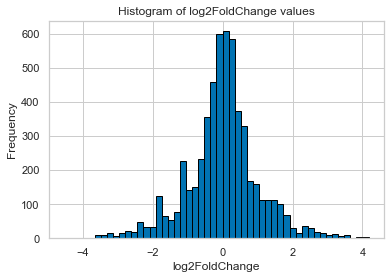

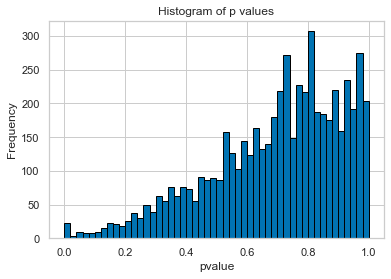

25 DE genes


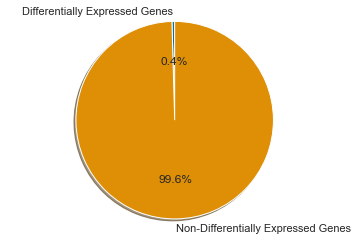

In [404]:
# plot log2fc distribution
plt.hist(conc_df['log2FoldChange'], bins=50, edgecolor='black')
plt.xlabel('log2FoldChange')
plt.ylabel('Frequency')
plt.title('Histogram of log2FoldChange values')
plt.show()

# plot pvalues distribution
plt.hist(conc_df['pvalue'], bins=50, edgecolor='black')
plt.xlabel('pvalue')
plt.ylabel('Frequency')
plt.title('Histogram of p values')
plt.show()

# determine DE value threshold nad plot percentage 
counts = ((conc_df['log2FoldChange'] > 1) | (conc_df['log2FoldChange'] < -1)) & (conc_df['pvalue'] < 0.05)
count = counts.sum()
print(str(count)+' DE genes')

# Plot the pie chart
labels = ['Differentially Expressed Genes', 'Non-Differentially Expressed Genes']
sizes = [count, len(conc_df)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

#### DE gene counts per class

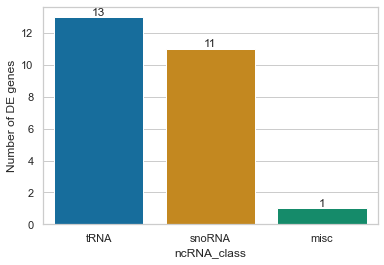

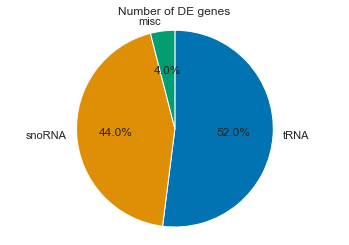

In [405]:
# count DE ncRNAs
differentially_expressed = conc_df[((conc_df['log2FoldChange'] < -1) | (conc_df['log2FoldChange'] > 1)) & (conc_df['pvalue'] < 0.05)]
differentially_expressed

# create a dictionary to store the counts ncRNA lasses
counts = {}

# iterate over the rows in the df2 gene id
for row in differentially_expressed[differentially_expressed.columns[0]]:
    split_line = row.split('_')
    ncRNA_class = split_line[1].strip()
    counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1

# create a dataframe to store the result
DE_classes_df = pd.DataFrame(list(counts.items()), columns=['ncRNA_class', 'Count'])

# Get the count data
counts = DE_classes_df['Count'].tolist()
labels = DE_classes_df['ncRNA_class'].tolist()

# Plot the bar plot using seaborn
sns.barplot(x='ncRNA_class', y='Count', data=DE_classes_df)

# Add the count on top of each bar
for i in range(len(DE_classes_df)):
    count = DE_classes_df['Count'].iloc[i]
    plt.text(i, count, count, ha='center', va='bottom')

plt.ylabel("Number of DE genes")
plt.show()


# Plot the pie chart
plt.pie(counts, labels=labels, startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Number of DE genes")
plt.show()


####  pvalues, log2fc, and DE gene % for each class

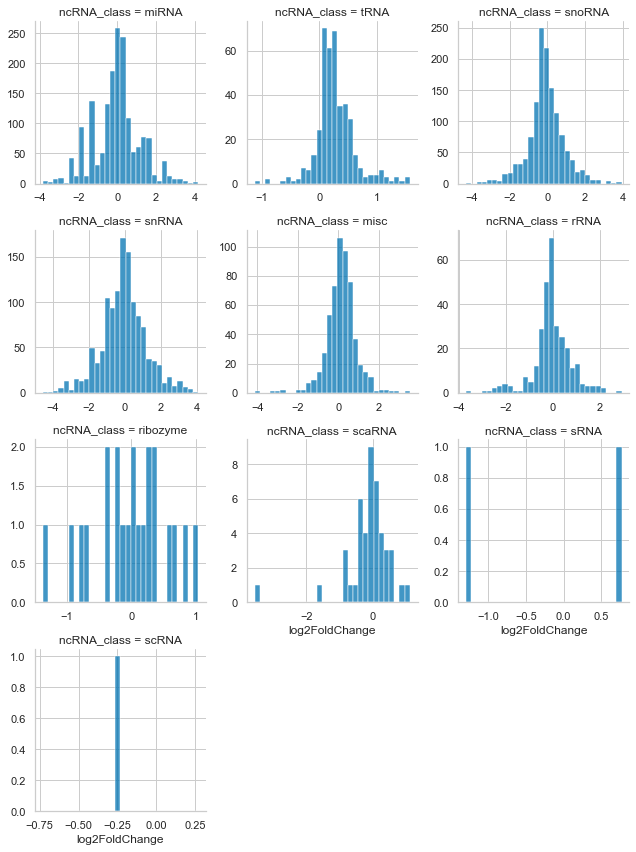

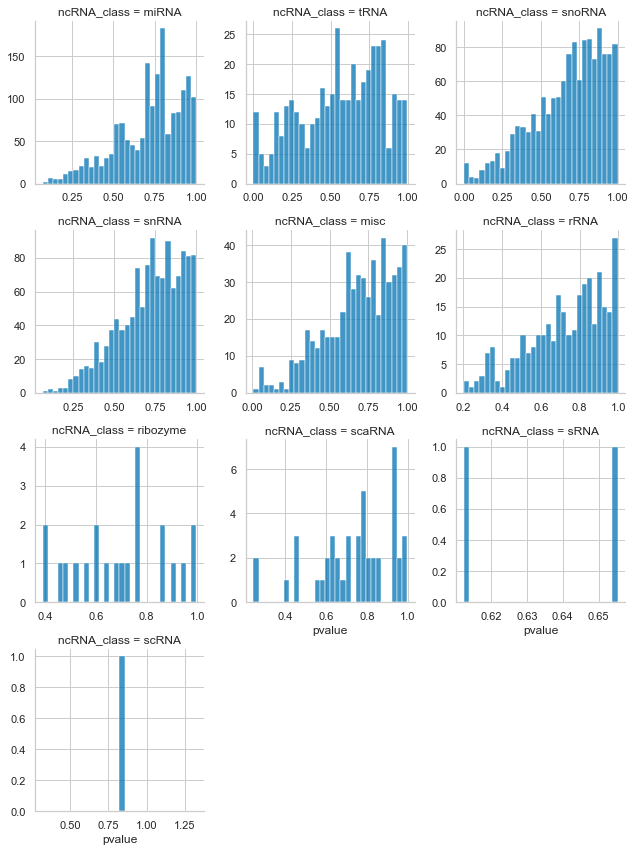

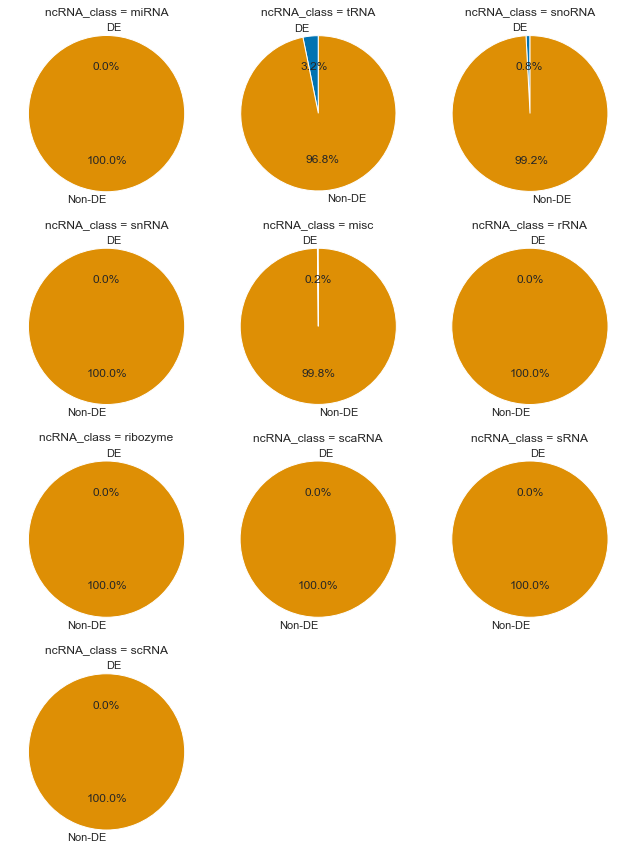

In [406]:
# Split the id column to extract ncRNA class
conc_df['ncRNA_class'] = conc_df['id'].apply(lambda x: x.split("_")[1])

# Define a function to plot the histogram of log2FoldChange and pvalue for each ncRNA class
def plot_histogram(feature):
    g = sns.FacetGrid(conc_df, col='ncRNA_class', col_wrap=3, sharex=False, sharey=False)
    g.map(sns.histplot, feature, bins=30)

# Define a function to plot a pie chart for each ncRNA class
def plot_piechart(data, **kwargs):
    counts = ((data['log2FoldChange'] > 1) | (data['log2FoldChange'] < -1)) & (data['pvalue'] < 0.05)
    count = counts.sum()
    labels = ['DE', 'Non-DE']
    sizes = [count, len(data) - count]
        
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')

# Plot histograms for log2fc and pvalues
plot_histogram('log2FoldChange')
plot_histogram('pvalue')

# Plot a pie chart for each ncRNA class

g = sns.FacetGrid(conc_df, col='ncRNA_class', col_wrap=3, sharex=False, sharey=False, height=3)
g.map_dataframe(plot_piechart)


plt.show()


#### volcano plot per class

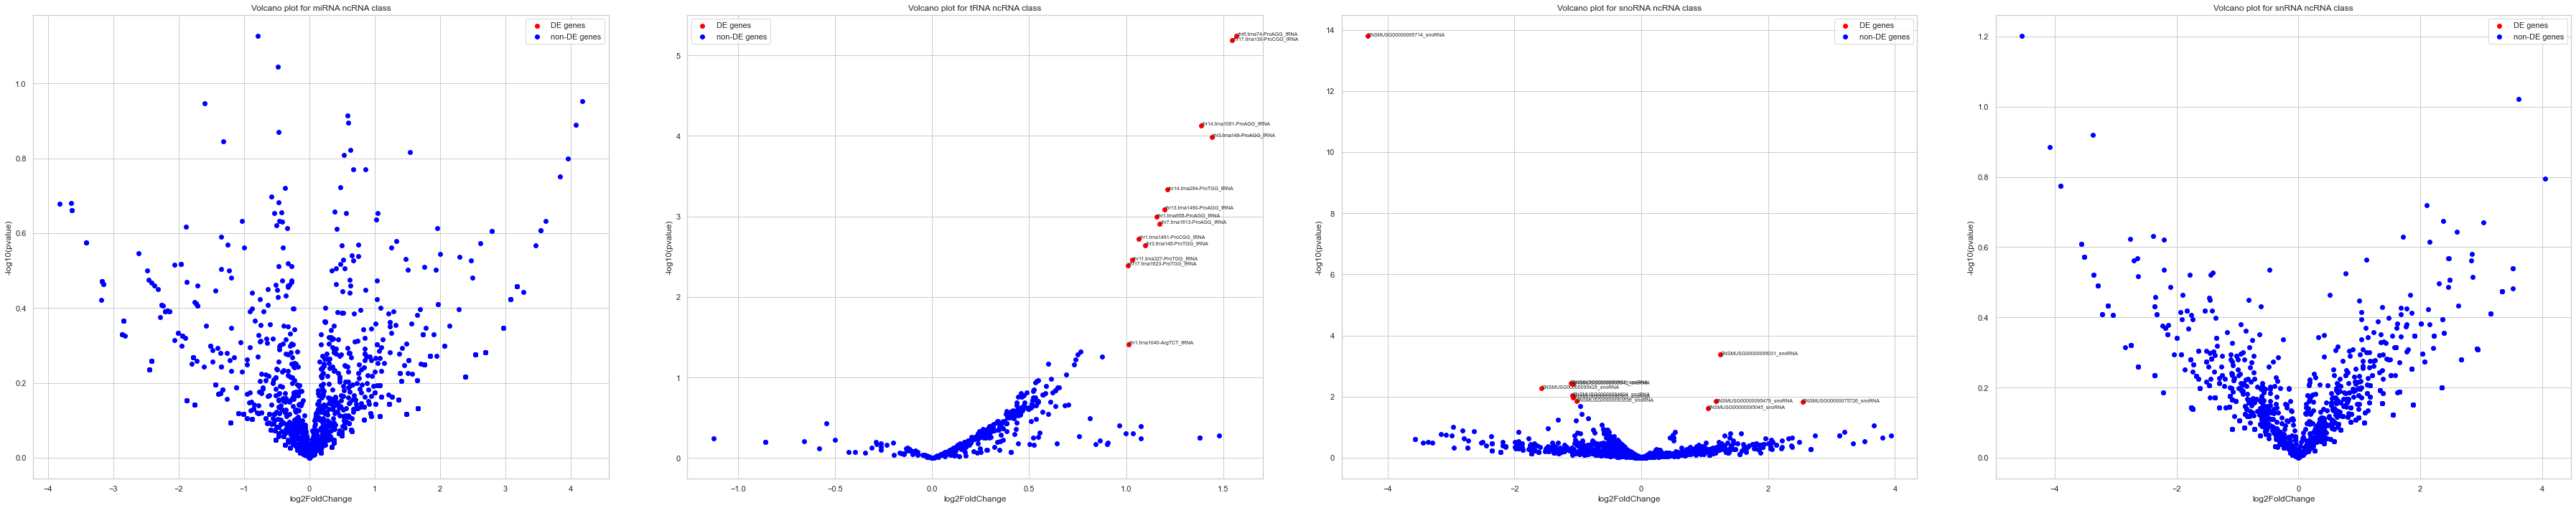

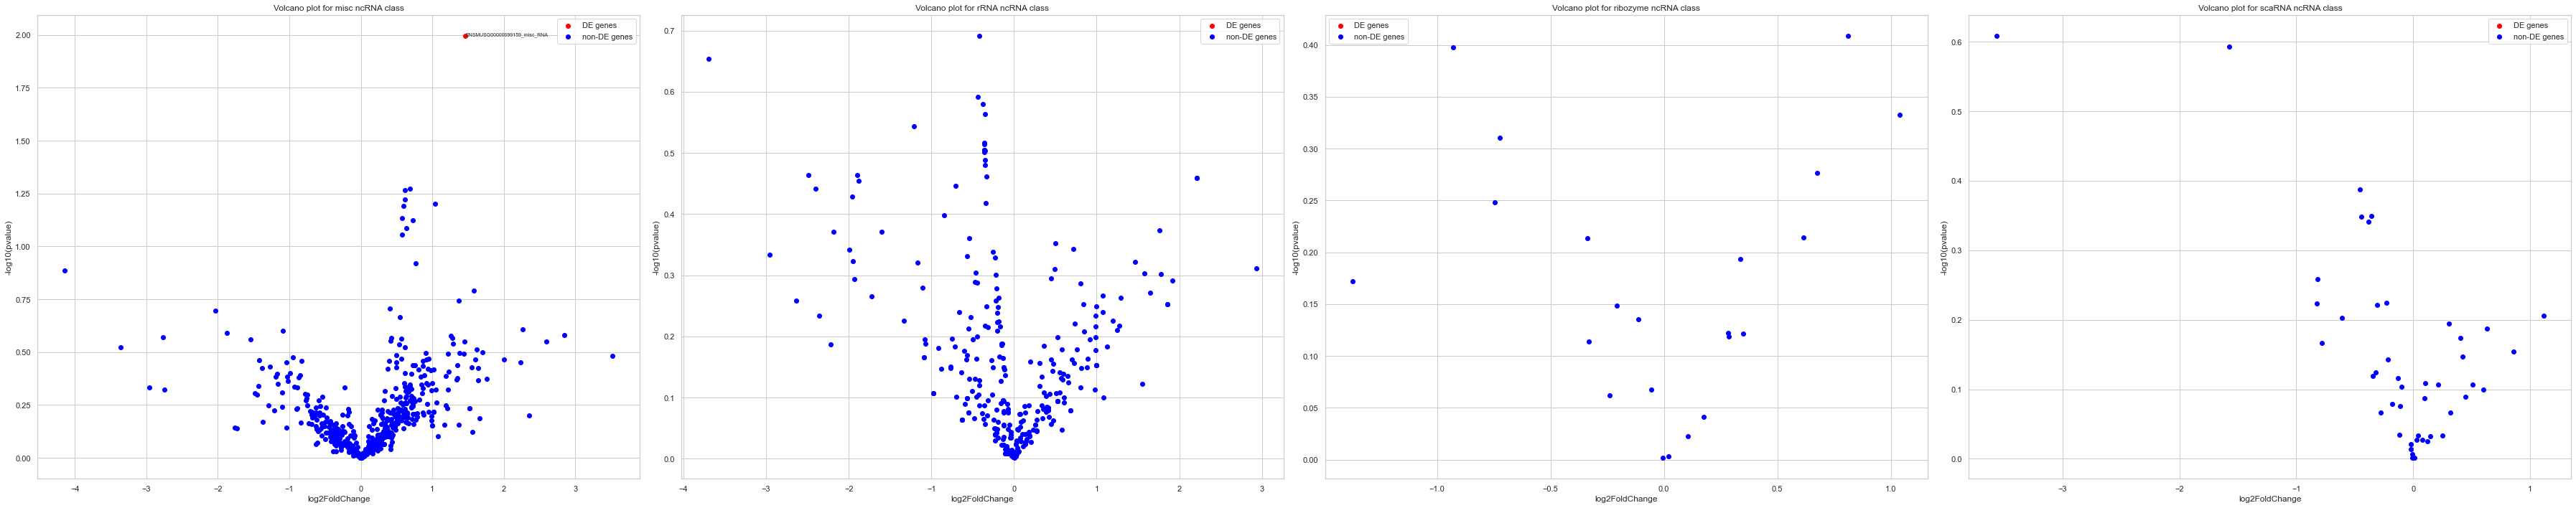

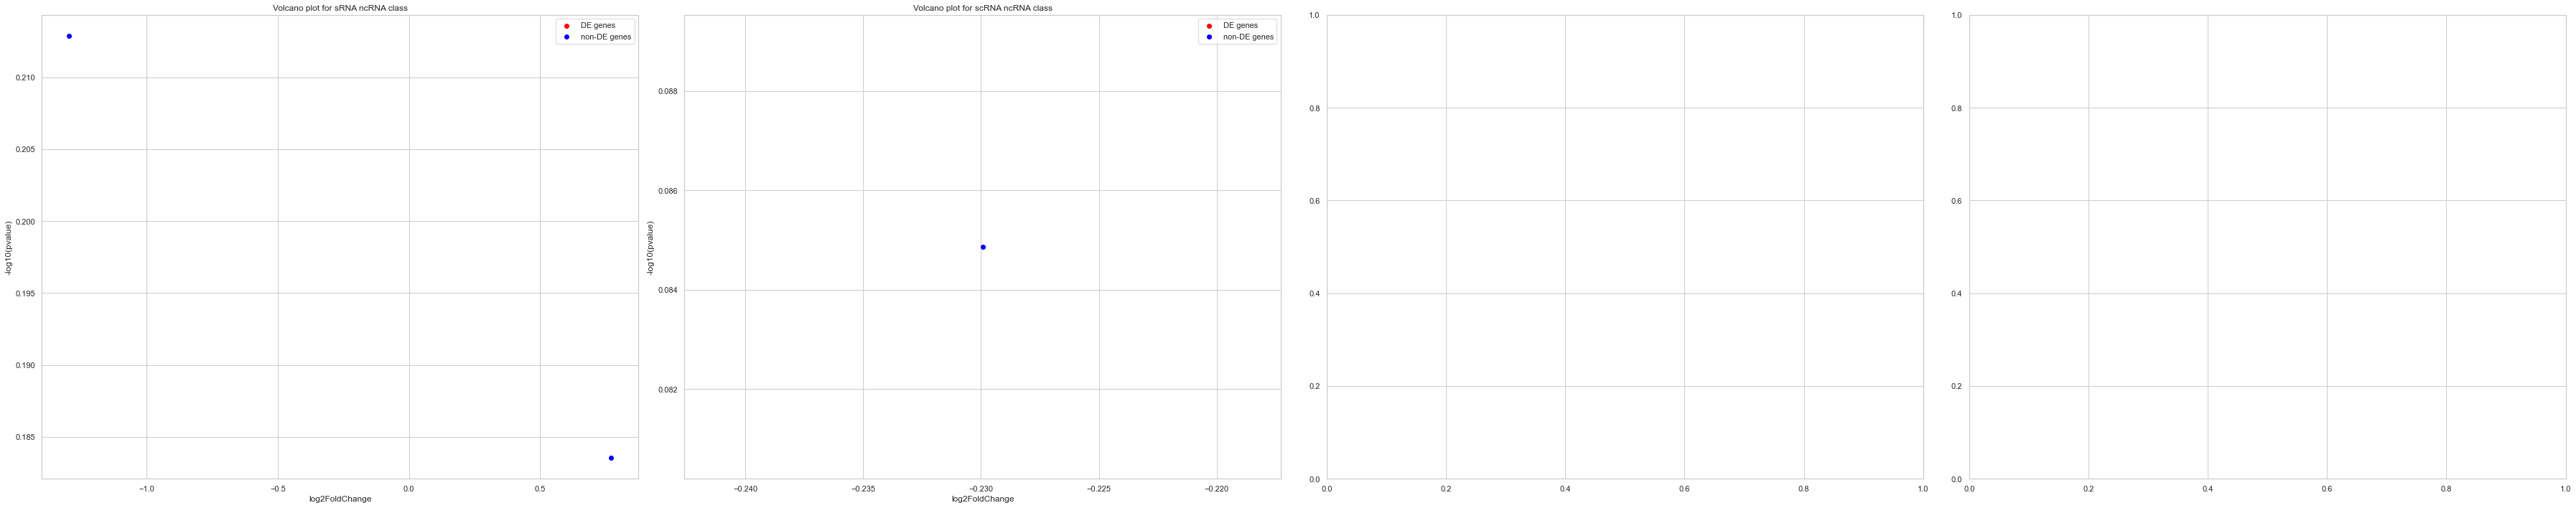

In [407]:
# Volcano plot
def plot_volcano(filtered_df, de_genes_class, ncRNA_class, ax=None):
    if ax is None:
        ax = plt.gca()
    # Plot the differentially expressed genes in red
    ax.scatter(de_genes_class["log2FoldChange"], -np.log10(de_genes_class["pvalue"]), color='red', label='DE genes')

    # Add the id labels for the DE genes
    for i, row in de_genes_class.iterrows():
        ax.annotate(row["id"], (row["log2FoldChange"], -np.log10(row["pvalue"])), fontsize=7)

    # Plot the remaining genes in blue
    non_de_genes_class = filtered_df[~filtered_df.index.isin(de_genes_class.index)]
    ax.scatter(non_de_genes_class["log2FoldChange"], -np.log10(non_de_genes_class["pvalue"]), color='blue', label='non-DE genes')

    # Add the ncRNA label to the plot
    ax.set_xlabel("log2FoldChange")
    ax.set_ylabel("-log10(pvalue)")
    ax.set_title(f"Volcano plot for {ncRNA_class} ncRNA class")
    ax.legend()

# Get the list of unique ncRNA classes from the "id" column
ncRNA_classes = conc_df["id"].apply(lambda x: x.split("_")[1]).unique()

fig_num = 1
for i in range(0, len(ncRNA_classes), 4):
    fig, axs = plt.subplots(1, 4, figsize=(50, 10))
    for j, ncRNA_class in enumerate(ncRNA_classes[i:i+4]):
        # Filter the data for the current ncRNA class
        filtered_df = conc_df[conc_df["id"].apply(lambda x: x.split("_")[1] == ncRNA_class)]
        de_genes_class = de_genes[de_genes["id"].apply(lambda x: x.split("_")[1] == ncRNA_class)]
        plot_volcano(filtered_df, de_genes_class, ncRNA_class, axs[j])
        
    plt.tight_layout()
    plt.show()
    fig_num += 1


#### heatmap for DE genes

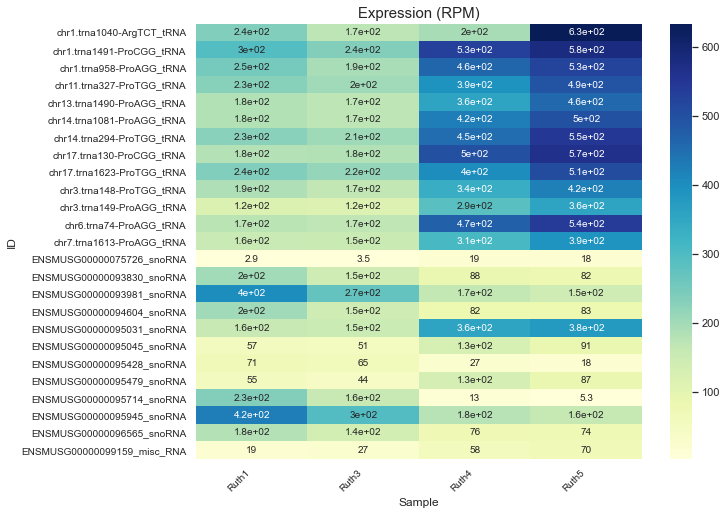

In [408]:
# Subset the differentially expressed genes
diff_exp_gene_values = differentially_expressed.iloc[:,3:]

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(diff_exp_gene_values, xticklabels=diff_exp_gene_values.columns, yticklabels=differentially_expressed["id"], cmap="YlGnBu", annot=True, annot_kws={"size": 10})

# Add labels and title
plt.xlabel("Sample", fontsize=12)
plt.ylabel("ID", fontsize=12)
plt.title("Expression (RPM)", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()


#### DE gene list

In [411]:
de_genes

,id,log2FoldChange,pvalue,Ruth1,Ruth3,Ruth4,Ruth5,ncRNA_class
8,chr1.trna1040-ArgTCT_tRNA,1.011623,3.867694e-02,238.861952,172.627730,196.337189,633.031600,tRNA
22,chr1.trna1491-ProCGG_tRNA,1.064610,1.901990e-03,295.664489,236.136260,530.026145,579.072566,tRNA
29,chr1.trna958-ProAGG_tRNA,1.155729,1.016245e-03,251.970229,193.989690,463.456884,526.429605,tRNA
77,chr11.trna327-ProTGG_tRNA,1.030884,3.484529e-03,231.579575,202.649945,392.674378,493.527755,tRNA
142,chr13.trna1490-ProAGG_tRNA,1.197838,8.247940e-04,184.972365,171.473030,358.125774,459.309830,tRNA
...,...,...,...,...,...,...,...,...
3546,ENSMUSG00000095479_snoRNA,1.173379,1.430077e-02,55.346062,43.878620,133.981172,86.860885,snoRNA
3569,ENSMUSG00000095714_snoRNA,-4.312349,1.592290e-14,234.492526,158.771324,13.482382,5.264296,snoRNA
3594,ENSMUSG00000095945_snoRNA,-1.078857,3.811157e-03,423.834317,296.758038,177.798914,161.877104,snoRNA
3678,ENSMUSG00000096565_snoRNA,-1.078423,1.061533e-02,180.602939,136.832014,75.838399,73.700145,snoRNA


#### DE ncRNA sequence

In [412]:
# extract the 'id' column as a list
ids = differentially_expressed['id'].str.split('_').str[0].tolist()

# initialize an empty dictionary to store the sequences
sequences = {}

# initialize an empty string to store the current sequence
sequence = ''

# initialize a flag to keep track of header lines
header_line = True

# iterate over the lines in the fasta file
for line in lines:
    # if the line starts with a '>', it is a header line
    if line.startswith('>'):
        # if it's not the first header line
        if not header_line:
            # check if the header is in the 'ids' list
            if header in ids:
                # store the sequence in the dictionary
                sequences[header] = sequence
        # remove the '>' symbol and split the header on spaces
        header = line[1:].strip().split()[0]
        # reset the sequence
        sequence = ''
        # update the header line flag
        header_line = True
    # if the line does not start with a '>', it is a sequence line
    else:
        # add the line to the current sequence
        sequence += line.strip()
        # update the header line flag
        header_line = False

# store the final sequence in the dictionary
sequences[header] = sequence

# print the sequences for each id
for id in ids:
    if id in sequences:
        print(f">{id}\n{sequences[id]}")
    else:
        print(f"{id} not found in fasta file")


>chr1.trna1040-ArgTCT
AAGGTATGTGCTTTTTCAGTTCTGGTGCTGATGCTGTGTGTGTGGTGAGGTCTCTGTGGCGCAATGGACGAGCGCGCTGGACTTCTAATCCAGAGGTTCTGGGTTCGAGTCCCGGCAGAGATGATCACCTGGCATGTGCCTCTTTTGTTTTGAATGTTGTCATGCTAGGTTGG
>chr1.trna1491-ProCGG
AGCCCCGCGGAAGCCTTAAGGGAGGCCCTGAGAGCGTCGTCACCGAGAGCGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTCGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTGGTTTTACTTTTTTTTTTCTTTTCGTGAAAAAAATTTACATATTGAAA
>chr1.trna958-ProAGG
TAAGAATTTCAATAGACCTTTATGATGACAGGAGAACCAGCTACACATCGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTGTAGCTTTTTAATTTTTCTTTTTTTTTGGTTGATACGTTAATGCACAGA
>chr11.trna327-ProTGG
TTTTCATACACAGAACAATTATGATTTGTTTTAGCGGGCCACATCAGCTGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTTGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCAAGCATTTTACATTTGTTTTGGTTTGGGGCAGTAATTAGGGACTCTCAGC
>chr13.trna1490-ProAGG
AAAAGAATTGGTTAAATGATTAAGAAAACGAAGAAACAAAGTTTACATCTGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCAAGTTTTTATCGTGTTTCCTGTCACCGAATTTTCGAAGGTTCAAAATTA
>chr14.trna1081-ProAGG
ACAGG